In [1]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask 


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [4]:
# 2. Remove dodgy images
import cv2
import imghdr

data_dir = 'ISIC/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
allowed_classes =['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

for image_class in os.listdir(data_dir):
    if image_class not in allowed_classes:
        continue 
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

C:\Users\ADEBOSS\AppData\Local\Temp\ipykernel_11908\1885920815.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

# Load Data with Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),       # Randomly flip images horizontally
    RandomRotation(0.2),            # Randomly rotate images by a maximum of 20%
    RandomZoom(0.2)                 # Randomly zoom images by a maximum of 20%
])

data = tf.keras.utils.image_dataset_from_directory(
    'ISIC/train', 
    labels='inferred', 
    label_mode='int', 
    validation_split=0.2,           # Use 20% of the data for validation
    subset='training',              # Specify training subset for data augmentation
    seed=123,                       # Set a random seed for reproducibility
    image_size=(256, 256),          # Set the desired image size for data augmentation
    batch_size=32                   # Set the batch size
)

# Increase dataset size using data augmentation
def generator():
    for batch in data:
        # Convert the original images to float32 before applying data augmentation
        original_images = tf.image.convert_image_dtype(batch[0], tf.float32)
        for i in range(5):  # Augment each batch 5 times
            augmented_images = data_augmentation(original_images, training=True)  # Apply data augmentation
            # Keep the original labels for the augmented images
            yield augmented_images, batch[1]

augmented_data = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.int32)))

print("New size of the dataset after data augmentation:", len(list(augmented_data.as_numpy_iterator())))

data_iterator = augmented_data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
for row in range(5):
    for col in range(4):
        idx = row * 4 + col
        img = batch[0][idx]
        label = batch[1][idx]
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(label)
plt.show()

Found 1043 files belonging to 3 classes.
Using 835 files for training.


InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Pack] name: 0

In [ ]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.80196077, 0.68235296, 0.57254905],
          [0.80588233, 0.6784314 , 0.5627451 ],
          [0.7705882 , 0.65294117, 0.51960784],
          ...,
          [0.7588235 , 0.58235294, 0.48235294],
          [0.7607843 , 0.5882353 , 0.49019608],
          [0.7392157 , 0.57254905, 0.45686275]],
 
         [[0.80784315, 0.70392156, 0.5980392 ],
          [0.7980392 , 0.68235296, 0.5686275 ],
          [0.79019606, 0.672549  , 0.5568628 ],
          ...,
          [0.7529412 , 0.5745098 , 0.48235294],
          [0.7509804 , 0.5901961 , 0.49411765],
          [0.7254902 , 0.5803922 , 0.4745098 ]],
 
         [[0.7941176 , 0.7058824 , 0.5980392 ],
          [0.80196077, 0.6901961 , 0.58235294],
          [0.7941176 , 0.6764706 , 0.56666666],
          ...,
          [0.74509805, 0.57254905, 0.4745098 ],
          [0.7509804 , 0.5901961 , 0.49215686],
          [0.74509805, 0.5882353 , 0.4862745 ]],
 
         ...,
 
         [[0.6745098 , 0.57254905, 0.4392157 ],
          [0.69411

In [ ]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [ ]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 4 output classes
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
23/23 [==============================] - 172s 6s/step - loss: 0.9662 - accuracy: 0.5353 - val_loss: 0.7905 - val_accuracy: 0.6562
Epoch 2/30
23/23 [==============================] - 82s 3s/step - loss: 0.7031 - accuracy: 0.6943 - val_loss: 0.6822 - val_accuracy: 0.7188
Epoch 3/30
23/23 [==============================] - 106s 5s/step - loss: 0.6085 - accuracy: 0.7378 - val_loss: 0.5115 - val_accuracy: 0.7656
Epoch 4/30
23/23 [==============================] - 96s 4s/step - loss: 0.5499 - accuracy: 0.7649 - val_loss: 0.5622 - val_accuracy: 0.7396
Epoch 5/30
23/23 [==============================] - 71s 3s/step - loss: 0.5246 - accuracy: 0.7840 - val_loss: 0.5601 - val_accuracy: 0.7448
Epoch 6/30
23/23 [==============================] - 218s 10s/step - loss: 0.4611 - accuracy: 0.8057 - val_loss: 0.5180 - val_accuracy: 0.7708
Epoch 7/30
23/23 [==============================] - 247s 11s/step - loss: 0.4105 - accuracy: 0.8274 - val_loss: 0.4955 - val_accuracy: 0.7812
Epoch 8/30
23/

21/23 [==========================>...] - ETA: 17s - loss: 0.3895 - accuracy: 0.8274

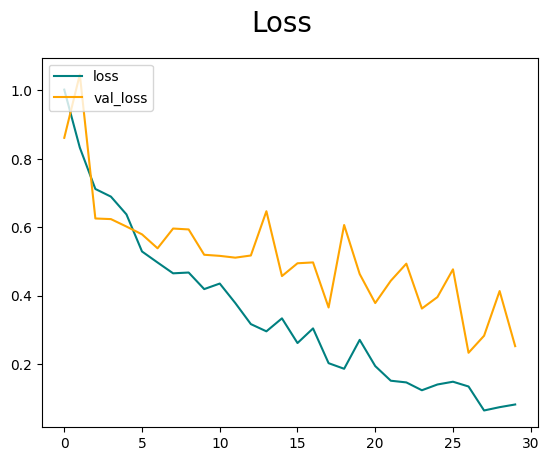

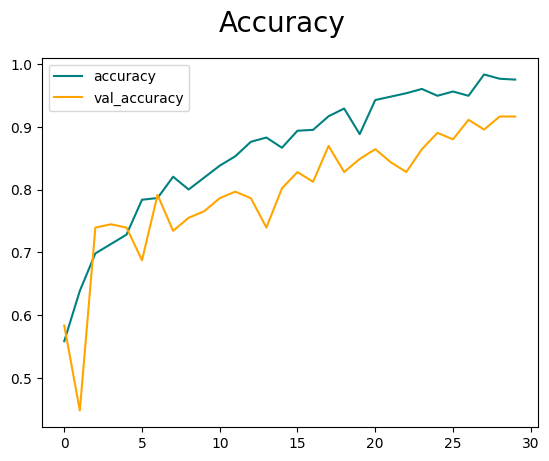

In [ ]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 1s 686ms/step
tf.Tensor(0.9811321, shape=(), dtype=float32) tf.Tensor(0.88135594, shape=(), dtype=float32) tf.Tensor(0.7083333, shape=(), dtype=float32)


In [ ]:
# 10. Test
import cv2

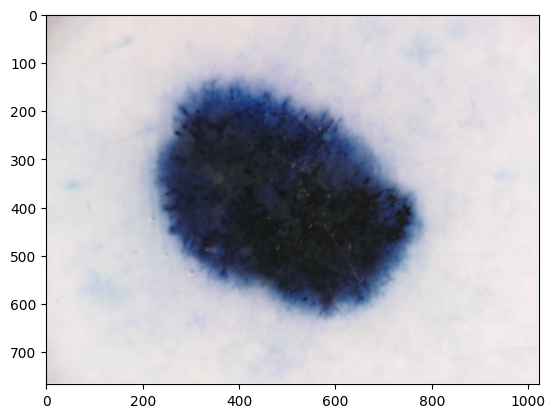

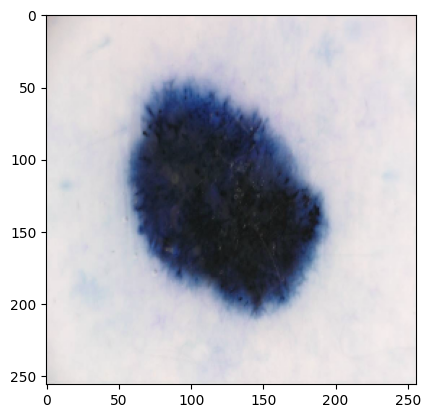

1/1 [==============================] - 0s 56ms/step
score : [array([[4.0501758e-02, 9.5890176e-01, 5.9647230e-04]], dtype=float32)]
Predicted class is a melanoma


In [ ]:

img = cv2.imread('ISIC/Train/melanoma/ISIC_0000013.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = np.argmax(yhat)  # Get the index of the highest probability class

classes = ['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']
print(f'score : {[predicted_class]}')
if classes[predicted_class] in allowed_classes:
    print(f'score : {[yhat]}')
    print(f'Predicted class is a {classes[predicted_class]}')
else:
    print('Error: Image does not belong to skin cancer class.')

In [ ]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifiers.h5'))
new_model = load_model('models/imageclassifiers.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 0s 158ms/step


array([[4.7458873e-36, 1.0000000e+00, 1.4154050e-23]], dtype=float32)